In [2]:
# refresh
%load_ext autoreload
%autoreload 2

In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import yaml

# PCA
from sklearn.decomposition import PCA


%matplotlib inline

In [24]:
# load data
CONFIG_FILE = '../experiments/train_mnist.yaml'
RUN_NAME = 'mnist_mlp_20230607-060024'

# 'mnist_mlp_20230607-054432'

# load config
with open(CONFIG_FILE) as f:
    config = yaml.safe_load(f)

# get data
save_dir = config["save_dir"]

# save_dir actually starts with ../
save_dir = '../' + save_dir

model_params = config["model"]
dataset_params = config["data"]
training_params = config["training"]
logging_params = config["logging"]

# get saving directories
save_dir = pathlib.Path(save_dir)

run_dir = save_dir / RUN_NAME

model_save_dir = run_dir / model_params["model_save_dir"]
model_save_path = model_save_dir / (RUN_NAME + ".ckpt")

activations_save_dir = run_dir / model_params["activations_save_dir"]
activations_save_path = activations_save_dir / ("activations" + ".h5")

gradients_save_dir = run_dir / model_params["gradients_save_dir"]
gradients_save_path = gradients_save_dir / ("gradients" + ".h5")

weight_gradients_save_dir = run_dir / model_params["weights_save_dir"]
weight_gradients_save_path = weight_gradients_save_dir / ("weight_gradients" + ".h5")

weights_save_dir = run_dir / model_params["weights_save_dir"]
weights_save_path = weights_save_dir / ("weights" + ".h5")

logger_csv = model_save_dir / 'lightning_logs' / 'version_0' / 'metrics.csv'

In [36]:
# load data
df = pd.read_csv(logger_csv)

# select rows where train_loss_step is not nan
train_step_df = df[df['train_loss_step'].notna()]
valid_step_df = df[df['val_loss_step'].notna()]

# select rows where train_loss_epoch is not nan
train_epoch_df = df[df['train_loss_epoch'].notna()]
valid_epoch_df = df[df['val_loss_epoch'].notna()]

max_step = max(train_step_df['step']) + 1
max_epoch = int(max(train_epoch_df['epoch'])) + 1
max_step, max_epoch

(23450, 50)

### Plotting weight space

In [62]:
# load the weight matrices as an .h5 file
import h5py

split = 'train'
layer_names = ['fc_layers.{i}.weight'.format(i=i) for i in range(3)]

weight_dict = {layer_name: [] for layer_name in layer_names}

with h5py.File(weights_save_path, 'r') as f:
    for epoch_num in range(max_epoch):
        epoch_group = f'epoch_{epoch_num:03d}'
        # print(epoch_group)
        for layer_name in layer_names:
            # get the weights for this layer
            weights = np.array(f[epoch_group][split][layer_name])

            # append to the list
            weight_dict[layer_name].append(weights)

# convert to numpy arrays
for layer_name in layer_names:
    weight_dict[layer_name] = np.array(weight_dict[layer_name])
    # reshape to (epoch, row * col)
    weight_dict[layer_name] = weight_dict[layer_name].reshape(max_epoch, -1)
    print(weight_dict[layer_name].shape)

(50, 200704)
(50, 65536)
(50, 2560)


In [71]:
# elbow method to determine best k for PCA
from sklearn.decomposition import PCA

elbow_dict = {layer_name: [] for layer_name in layer_names}
elbow_dict['k'] = [1, 2, 3, 4, 5, 10, 20, 50]

for layer_name in layer_names:
    for k in elbow_dict['k']:
        pca = PCA(n_components=k)
        pca.fit(weight_dict[layer_name])
        print(k, pca.explained_variance_ratio_.sum())

        elbow_dict[layer_name].append(pca.explained_variance_ratio_.sum())


1 0.80617756
2 0.9203049
3 0.95536107
4 0.97020245
5 0.97785985
10 0.9898628
20 0.9952135
50 0.9999999
1 0.88336825
2 0.9557269
3 0.977377
4 0.9852309
5 0.9887958
10 0.99467164
20 0.9975657
50 1.0
1 0.94440633
2 0.9775238
3 0.98894674
4 0.99323654
5 0.9951274
10 0.9979398
20 0.99911386
50 1.0


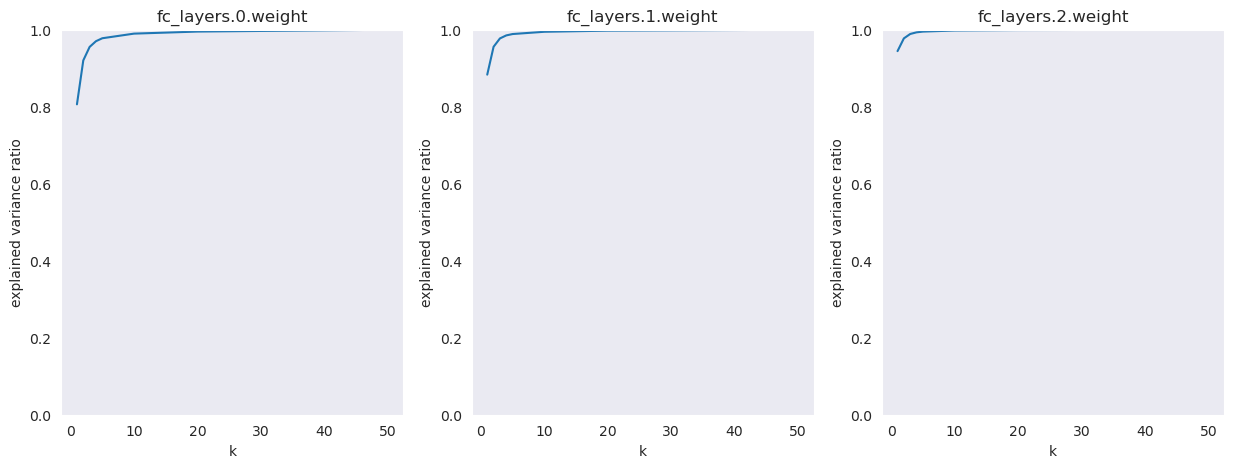

In [70]:
# plot elbow method
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, layer_name in enumerate(layer_names):
    ax[i].plot(elbow_dict['k'], elbow_dict[layer_name])
    ax[i].set_title(layer_name)
    ax[i].set_xlabel('k')
    ax[i].set_ylabel('explained variance ratio')
    ax[i].set_ylim(0, 1)
    ax[i].grid()

In [73]:
# fitting PCA
k = 2

# separate PCA for each layer
pca_dict = {layer_name: PCA(n_components=k) for layer_name in layer_names}

# fit PCA
for layer_name in layer_names:
    pca_dict[layer_name].fit(weight_dict[layer_name])



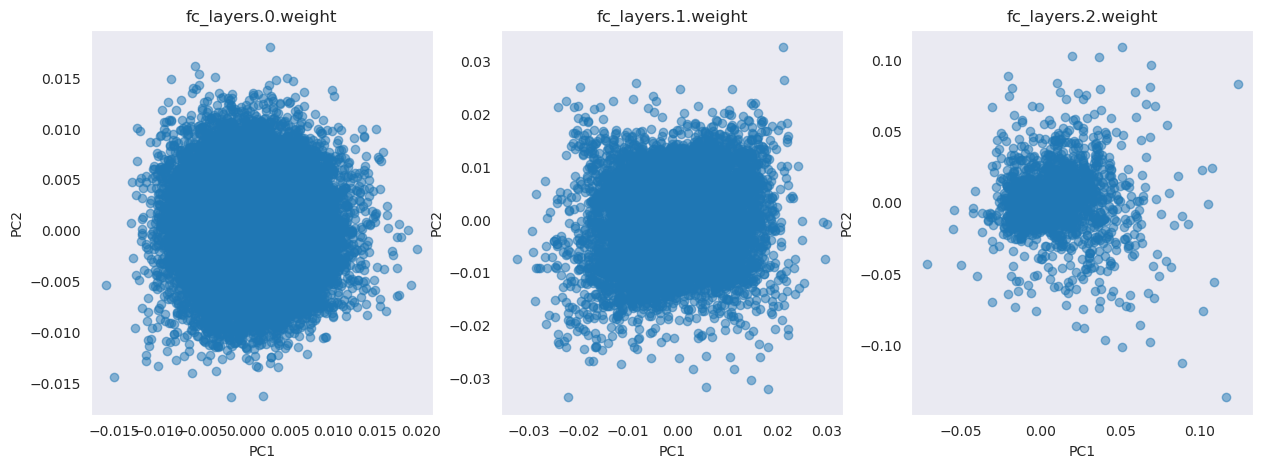

In [74]:
# plot PCA
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, layer_name in enumerate(layer_names):
    ax[i].scatter(
        pca_dict[layer_name].components_[0],
        pca_dict[layer_name].components_[1],
        alpha=0.5,
    )
    ax[i].set_title(layer_name)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].grid()

In [78]:
pca_dict['fc_layers.0.weight'].components_.shape

(2, 200704)

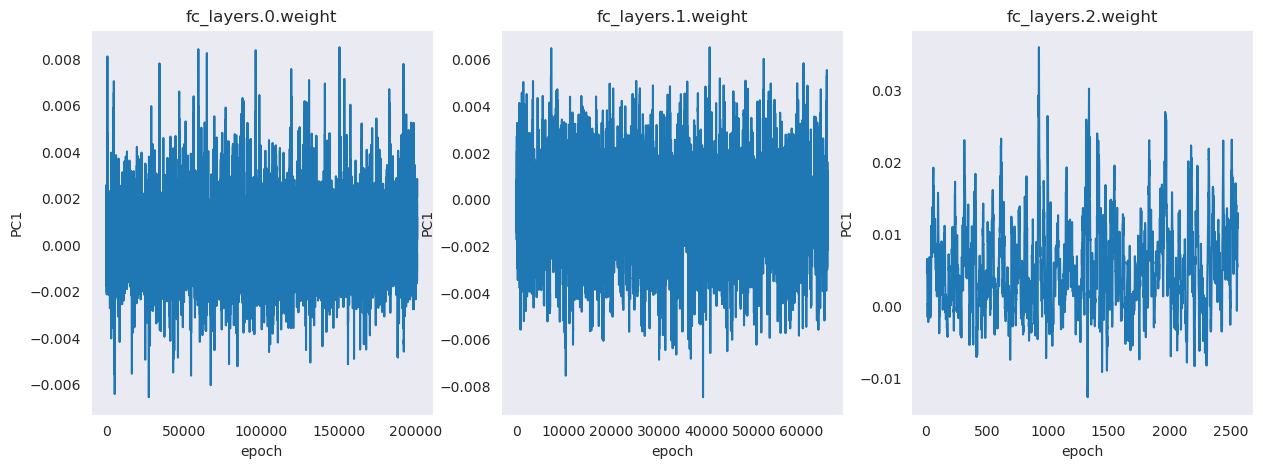

In [86]:
# check the first axis of variance and how it changes over epochs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

smoothing = True
smooth_window = 10
pc_dimension = 0

for i, layer_name in enumerate(layer_names):
    to_plot = pca_dict[layer_name].components_[pc_dimension]
    if smoothing:
        # to_plot = np.convolve(to_plot, np.ones(smooth_window), 'valid') / smooth_window
        to_plot = pd.Series(to_plot).rolling(smooth_window).mean().values

    # use seaborn to plot
    sns.lineplot(x=np.arange(len(to_plot)), y=to_plot, ax=ax[i])

    ax[i].set_title(layer_name)
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('PC1')
    ax[i].grid()


In [ ]:
# PSD on the axes of variance


In [54]:
test_write_h5 = h5py.File('lol.h5', 'w')
test_write_h5.create_dataset('test', data=np.random.rand(469, 256, 784))
test_write_h5.close()

test_h5 = h5py.File('lol.h5', 'r')
print(test_h5['test'][:].shape)
test_h5.close()

<HDF5 dataset "test": shape (469, 256, 784), type "<f8">